In [65]:

import os
import argparse
import time
from getpass import getuser
from distutils.dir_util import copy_tree
import pickle

import numpy as np
import random
import theano
import theano.tensor as T
from theano import config
import lasagne
from lasagne.regularization import regularize_network_params
from lasagne.objectives import categorical_crossentropy
from lasagne.objectives import categorical_accuracy

import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import gridspec

#from fcn_1D_general import buildFCN_1D
from metrics import accuracy, crossentropy
from cortical_layers import ParcellationDataset
from classif_model import classif_model, dense_model
%matplotlib inline



In [50]:

SAVEPATH = '/data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/'
LOADPATH = '/data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/'
WEIGHTS_PATH = LOADPATH


In [51]:

#Model hyperparameters
n_filters = 32
filter_size = [15]#[7,15,25,49]
depth  = 2
data_augmentation={} #{'horizontal_flip': True, 'fill_mode':'constant'}
block = 'bn_relu_conv'

#Training loop hyperparameters
weight_decay=0.001
num_epochs=500
max_patience=100
resume=False
learning_rate_value = 0.0005 #learning rate is defined below as a theano variable.



#Hyperparameters for the dataset loader
batch_size=[1000,1000,1]
smooth_or_raw = 'both'
shuffle_at_each_epoch = True
minibatches_subset = 0
n_layers = 6

In [52]:
_FLOATX = config.floatX

savepath=SAVEPATH
loadpath=LOADPATH

exp_name = 'classif_model_alldataset'
exp_name += '_lrate=' + str(learning_rate_value)
exp_name += '_fil=' + str(n_filters)
exp_name += '_fsizes=' + str(filter_size)
exp_name += '_depth=' + str(depth)
exp_name += '_data=' + smooth_or_raw
exp_name += '_decay=' + str(weight_decay)
exp_name += '_pat=' + str(max_patience)
exp_name += ('_noshuffle'+str(minibatches_subset)+'batch') if not shuffle_at_each_epoch else ''
#exp_name += 'test'

dataset = 'parcellation'
savepath = os.path.join(savepath, dataset, exp_name)
loadpath = os.path.join(loadpath, dataset, exp_name)
print 'Savepath : '
print savepath
print 'Loadpath : '
print loadpath

if not os.path.exists(savepath):
    os.makedirs(savepath)
else:
    print('\033[93m The following folder already exists {}. '
          'It will be overwritten in a few seconds...\033[0m'.format(
              savepath))

print('Saving directory : ' + savepath)
with open(os.path.join(savepath, "config.txt"), "w") as f:
    for key, value in locals().items():
        f.write('{} = {}\n'.format(key, value))


Savepath : 
/data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/parcellation/classif_model_alldataset_lrate=0.0005_fil=32_fsizes=[15]_depth=2_data=both_decay=0.001_pat=100
Loadpath : 
/data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/parcellation/classif_model_alldataset_lrate=0.0005_fil=32_fsizes=[15]_depth=2_data=both_decay=0.001_pat=100
 The following folder already exists /data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/parcellation/classif_model_alldataset_lrate=0.0005_fil=32_fsizes=[15]_depth=2_data=both_decay=0.001_pat=100. It will be overwritten in a few seconds...
Saving directory : /data1/users/kwagstyl/bigbrain/NeuralNetworks/Parcellation/NN/parcellation/classif_model_alldataset_lrate=0.0005_fil=32_fsizes=[15]_depth=2_data=both_decay=0.001_pat=100


In [53]:

input_var = T.tensor3('input_var') #n_example*nb_in_channels*ray_size
target_var = T.ivector('target_var') #n_example*ray_size

learn_step=  theano.shared(np.array(learning_rate_value, dtype=theano.config.floatX))


In [54]:

# Build dataset iterator
#

if smooth_or_raw =='both':
    nb_in_channels = 2
    use_threads = False
else:
    nb_in_channels = 1
    use_threads = True

train_iter = ParcellationDataset(
    which_set='train',
    smooth_or_raw = 'both',
    batch_size=batch_size[0],
    data_augm_kwargs=data_augmentation,
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)

val_iter = ParcellationDataset(
    which_set='valid',
    smooth_or_raw = 'both',
    batch_size=batch_size[1],
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)

test_iter = None

n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels

print 'nb batches train ' + str(n_batches_train) + ' valid ' + str(n_batches_val)



train /data1/users/kwagstyl/bigbrain/NeuralNetworks/cortical_layers/cortical_layers/Parcellation/training_cls.txt 5184
val /data1/users/kwagstyl/bigbrain/NeuralNetworks/cortical_layers/cortical_layers/Parcellation/training_cls.txt 5184
nb batches train 5 valid 1


In [55]:
train_iter = ParcellationDataset(
    which_set='train',
    smooth_or_raw = 'both',
    batch_size=batch_size[0],
    data_augm_kwargs=data_augmentation,
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)


train /data1/users/kwagstyl/bigbrain/NeuralNetworks/cortical_layers/cortical_layers/Parcellation/training_cls.txt 5184


In [56]:
val_iter = ParcellationDataset(
    which_set='valid',
    smooth_or_raw = smooth_or_raw,
    batch_size=batch_size[1],
    shuffle_at_each_epoch = shuffle_at_each_epoch,
    return_one_hot=False,
    return_01c=False,
    return_list=False,
    use_threads=use_threads)



val /data1/users/kwagstyl/bigbrain/NeuralNetworks/cortical_layers/cortical_layers/Parcellation/training_cls.txt 5184


In [57]:
test_iter = None



n_batches_train = train_iter.nbatches
n_batches_val = val_iter.nbatches
n_batches_test = test_iter.nbatches if test_iter is not None else 0
n_classes = train_iter.non_void_nclasses
void_labels = train_iter.void_labels
print 'nb batches train ' + str(n_batches_train) + ' valid ' + str(n_batches_val)



nb batches train 5 valid 1


In [58]:
model = dense_model()
simple_net_output, net = model.build_model(input_var, nb_in_channels = nb_in_channels)



In [59]:
print "Defining and compiling training functions"

prediction = lasagne.layers.get_output(simple_net_output[0])
loss = categorical_crossentropy(prediction, target_var)
loss = loss.mean()

if weight_decay > 0:
    weightsl2 = regularize_network_params(
        simple_net_output, lasagne.regularization.l2)
    loss += weight_decay * weightsl2
train_acc = T.mean(categorical_accuracy(prediction, target_var))

params = lasagne.layers.get_all_params(simple_net_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=learn_step)

train_fn = theano.function([input_var, target_var], [loss, train_acc],
                           updates=updates)

print "Done"





Defining and compiling training functions
Done


In [60]:
print "Defining and compiling valid functions"
valid_prediction = lasagne.layers.get_output(simple_net_output[0],
                                            deterministic=True)
valid_loss = categorical_crossentropy(valid_prediction, target_var)
valid_loss = valid_loss.mean()

valid_acc = T.mean(categorical_accuracy(valid_prediction, target_var))

valid_fn = theano.function([input_var, target_var],
                           [valid_loss, valid_acc])#,profile=True)
print "Done"



Defining and compiling valid functions
Done


In [61]:
err_train = []
acc_train = []



err_valid = []
acc_valid = []


patience = 10
# Training main loop
print "Start training"

for epoch in range(num_epochs):
    #learn_step.set_value((learn_step.get_value()*0.99).astype(theano.config.floatX))

    # Single epoch training and validation
    start_time = time.time()
    #Cost train and acc train for this epoch
    cost_train_epoch = 0
    acc_train_epoch = 0


    for i in range(n_batches_train):
        # Get minibatch (comment the next line if only 1 minibatch in training)
        train_batch = train_iter.next()
        X_train_batch, L_train_batch, idx_train_batch = train_batch['data'], train_batch['labels'], train_batch['indices'][0]


        L_train_batch = np.reshape(L_train_batch, np.prod(L_train_batch.shape))


        cost_train_batch, acc_train_batch = train_fn(X_train_batch, L_train_batch)

        #Update epoch results
        cost_train_epoch += cost_train_batch
        acc_train_epoch += acc_train_batch

    #Add epoch results
    err_train += [cost_train_epoch/n_batches_train]
    acc_train += [acc_train_epoch/n_batches_train]

    # Validation
    cost_val_epoch = 0
    acc_val_epoch = 0

    for i in range(n_batches_val):

        # Get minibatch (comment the next line if only 1 minibatch in training)
        val_batch = val_iter.next()
        X_val_batch, L_val_batch, idx_val_batch = val_batch['data'], val_batch['labels'], val_batch['indices'][0]

        L_val_batch = np.reshape(L_val_batch, np.prod(L_val_batch.shape))


        # Validation step
        cost_val_batch, acc_val_batch = valid_fn(X_val_batch, L_val_batch)
        #print i, 'validation batch cost : ', cost_val_batch, ' batch accuracy : ', acc_val_batch

        #Update epoch results
        cost_val_epoch += cost_val_batch
        acc_val_epoch += acc_val_batch



    #Add epoch results
    err_valid += [cost_val_epoch/n_batches_val]
    acc_valid += [acc_val_epoch/n_batches_val]

    #Print results (once per epoch)

    out_str = "EPOCH %i: Avg cost train %f, acc train %f, cost val %f, acc val %f, took %f s"
    out_str = out_str % (epoch, err_train[epoch],
                         acc_train[epoch],
                         err_valid[epoch],
                         acc_valid[epoch],
                         time.time()-start_time)
    print out_str
    # print out_str2



    # Early stopping and saving stuff

    with open(os.path.join(savepath, "fcn1D_output.log"), "a") as f:
        f.write(out_str + "\n")

    if epoch == 0:        
        best_acc_val = acc_valid[epoch]
    elif epoch > 1 and acc_valid[epoch] > best_acc_val:
        print('saving best (and last) model')
        best_acc_val = acc_valid[epoch]
        patience = 0
        np.savez(os.path.join(savepath, 'new_fcn1D_model_best.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_best.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid)
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid)
    else:
        patience += 1
        print('saving last model')
        np.savez(os.path.join(savepath, 'new_fcn1D_model_last.npz'),
                 *lasagne.layers.get_all_param_values(simple_net_output))
        np.savez(os.path.join(savepath , "fcn1D_errors_last.npz"),
                 err_train=err_train, acc_train=acc_train,
                 err_valid=err_valid, acc_valid=acc_valid)
    # Finish training if patience has expired or max nber of epochs reached

    if patience == max_patience or epoch == num_epochs-1:
        if savepath != loadpath:
            print('Copying model and other training files to {}'.format(loadpath))
            copy_tree(savepath, loadpath)
        break




Start training
EPOCH 0: Avg cost train 221.773302, acc train 0.439789, cost val 202.445323, acc val 0.493573, took 2.059717 s
EPOCH 1: Avg cost train 164.582016, acc train 0.516263, cost val 142.110917, acc val 0.516710, took 1.873151 s
saving last model
EPOCH 2: Avg cost train 106.212364, acc train 0.463960, cost val 103.903501, acc val 0.541131, took 1.872188 s
saving best (and last) model
EPOCH 3: Avg cost train 75.740173, acc train 0.564627, cost val 76.697940, acc val 0.438303, took 1.875944 s
saving last model
EPOCH 4: Avg cost train 55.947915, acc train 0.512123, cost val 66.430711, acc val 0.625964, took 2.089875 s
saving best (and last) model
EPOCH 5: Avg cost train 44.113902, acc train 0.593489, cost val 51.474559, acc val 0.480720, took 2.238270 s
saving last model
EPOCH 6: Avg cost train 33.847682, acc train 0.579723, cost val 43.233025, acc val 0.649100, took 2.268769 s
saving best (and last) model
EPOCH 7: Avg cost train 28.042809, acc train 0.592512, cost val 37.084904, 

KeyboardInterrupt: 

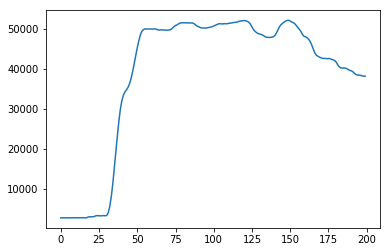

In [100]:
plt.plot(X_train_batch[670][0])

In [101]:
L_train_batch[670]

0